## **Super Dead Leaves - 3D**

-------------


The **SuperDeadLeaves3D** (SDL3D) pattern is a 3D extension of the Super Dead Leaves (SDL) pattern that creates a voxelized volume
completely filled with overlapping shapes randomly sampled using  Johan Gielis\' _superformula_ [4]. This stochastic object model is inspired by the texture reproduction 
fidelity chart Dead Leaves (DL) [1], defined in the international standards ISO-19567-2 [2] and IEEE-1858 [3]. 
 
In the SDL3D, the parameters of two independent _superformula_ [4] 2D shapes are randomly sampled within the user-requested range of values. 
We create a 3D volume in spheric coordinates by utilizing the two 2D shapes as the theta and phi angles, and setting the shape radius in 
each direction as the multiplication of the radii of the two superformulas. Unlike in the SDL pattern, the SDL3D does not (yet) randomize 
the parameters separately in each lobe. The final volume consists of a large number of overlapping shapes, with those sampled first occluding 
the following ones. The output volume values can contain two kinds of data: by default, a random value between 0 and 1 sampled for each shape; 
if the parameter enumerate_shapes=True, the number of the shape covering the voxel. Uncovered voxels have value 0.

The objective of the SDL3D pattern is to evaluate the performance of non-linear image processing algorithms and tomographic reconstruction 
algorithms based on machine-learning techniques, by using multiple realizations of these synthetic patterns generated at high-resolution 
and noise-free as a full-reference [5].

The _superformula_ equation [4], in polar coordinates, is given by the equation below. To create the 3D shapes, two instances of this equation are used to define the 
$\theta$ and $\phi$ angles and calculate the total radius in spheric coordinates:

\begin{equation}
r(\phi)  ,  r(\theta) = \left( \left| \frac{\cos\left(\frac{m \theta}{4}\right)}{a} \right|^{n_2} + \left| \frac{\sin\left(\frac{m \theta}{4}\right)}{b} \right|^{n_3} \right)^{-\frac{1}{n_1}}  ;  
r_{total} = r(\theta) \times r(\phi)
\end{equation}


  - [1] Cao, Guichard and Hornung, "Dead leaves model for measuring texture quality on a digital camera" in SPIE Digital Photography VI, vol. 7537, p. 126-133 (2010)
  - [2] ISO/TS 19567-2:2019, "Photography — Digital cameras, Part 2: Texture analysis using stochastic pattern" (2019)
  - [3] IEEE 1858-2023, "IEEE Standard for Camera Phone Image Quality (CPIQ)" (2023) 
  - [4] Johan Gielis. "A generic geometric transformation that unifies a wide range of natural and abstract shapes." American journal of botany 90, p. 333-338 (2003)
  - [5] Kirk, L., Herzer, P., Artmann, U., and Kunz, D., "Description of texture loss using the dead leaves target: current issues and a new intrinsic approach." SPIE Digital Photography X, 9023, p. 112–120 (2014)

-------------

**Author**: Andreu Badal (Andreu.Badal-Soler (at) fda.hhs.gov)

**Date**: 2024/12/18

**Disclaimer**
This software and documentation (the "Software") were developed at the US Food and Drug Administration (FDA) by employees of the Federal Government in the course of their official duties. Pursuant to Title 17, Section 105 of the United States Code, this work is not subject to copyright protection and is in the public domain. Permission is hereby granted, free of charge, to any person obtaining a copy of the Software, to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, or sell copies of the Software or derivatives, and to permit persons to whom the Software is furnished to do so. FDA assumes no responsibility whatsoever for use by other parties of the Software, its source code, documentation or compiled executables, and makes no guarantees, expressed or implied, about its quality, reliability, or any other characteristic. Further, use of this code in no way implies endorsement by the FDA or confers any advantage in regulatory decisions. Although this software can be redistributed and/or modified freely, we ask that any derivative works bear some notice that they are derived from it, and any modified versions bear some notice that they have been modified.

In [225]:
# - Magic commands
# %pip install --upgrade pip
# %pip install -q matplotlib scipy tifffile
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [226]:
# - Import external libraries:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import time

# Import the class from the new library:
from src.SuperDeadLeaves.SuperDeadLeaves3D import SuperDeadLeaves3D

print("Notebook execution start time: ", time.strftime("%y/%m/%d %I:%M:%S %p", time.localtime()))
# SuperDeadLeaves3D?

Notebook execution start time:  24/12/20 08:26:58 PM


## Example SuperDeadLeaves3D stochastic volume generation

In [368]:
# ** Generate a SuperDeadLeaves3D volume **

# Step 1: Define the volume size
vol_size = [512, 512, 51]

# Step 2: Initialize the SuperDeadLeaves3D generator
seed = np.random.randint(1e4, 1e5)  # Use None for a random initialization
print(f"\n ** SuperDeadLeaves3D generator initialized with seed={seed} and volume size={vol_size} **\n")

SDL3D = SuperDeadLeaves3D(vol_size, seed=seed, m_range1=[2, 6], m_range2=[2, 4], n1_range=[2, 5], n2_range=[5, 9], n3_range=[2, 5], rmin=0.005)  # 0.0015
#       - Note: set m_range1 and m_range2 to [2,2] to generate circular blobs, or [0,0] for spheres
# SDL3D.report()  # Report internal class variables

# Step 3: Generate the volume
max_shapes = 10000  # 65000
print(f"   Starting volume generation with up to {max_shapes} shapes...")
start_time = time.time()  # Record start time    

volume = SDL3D.generate(max_shapes=max_shapes, enumerate_shapes=False, verbose=True)  

end_time = time.time()  # Record end time
generation_time = end_time - start_time
print(f"\n   Volume generation completed in {generation_time:.2f} sec ({(SDL3D.final_shapes/generation_time):2e} shapes/sec).")

# Step 4: Export the volume as a multi-page TIFF file with the correct axis order for ImageJ (TZCYX)
output_file = f"SuperDeadLeaves3D_{seed}_shapes{SDL3D.final_shapes}_rmin{SDL3D.rmin}_{vol_size[0]}x{vol_size[1]}x{vol_size[2]}.tif"
print(f"   Exporting the final volume to file: {output_file}")   
tifffile.imwrite(output_file, volume.transpose(2,1,0))
# Optional: export as a raw binary file
# volume.tofile(output_file+".raw")    

# Step 5: Report basic statistics about the volume
filled_voxels = np.count_nonzero(volume)  # Count filled voxels
unique_shapes = np.max(volume)  # Count unique shapes
total_voxels  = np.prod(vol_size)  # Total voxels in the volume

print(f"\n   Volume Statistics (volume.shape={volume.shape}):")
print(  f"     Total Voxels: {total_voxels}")
print(  f"     Filled Voxels: {filled_voxels}")
print(  f"     Max. voxel value: {unique_shapes}")
print(  f"     Percentage Filled: {filled_voxels / total_voxels * 100:.2f}%")


 ** SuperDeadLeaves3D generator initialized with seed=19472 and volume size=[512, 512, 51] **

   Starting volume generation with up to 5000 shapes...
     Shape 500: Filled 3374528/13369344 voxels = 25.241%. Runtime: 9.90 s.
     Shape 1000: Filled 6612497/13369344 voxels = 49.460%. Runtime: 19.90 s.
     Shape 1500: Filled 8856010/13369344 voxels = 66.241%. Runtime: 29.10 s.
     Shape 2000: Filled 10138620/13369344 voxels = 75.835%. Runtime: 37.01 s.
     Shape 2500: Filled 10941035/13369344 voxels = 81.837%. Runtime: 45.19 s.
     Shape 3000: Filled 11722185/13369344 voxels = 87.680%. Runtime: 53.12 s.
     Shape 3500: Filled 12295858/13369344 voxels = 91.971%. Runtime: 61.04 s.
     Shape 4000: Filled 12571921/13369344 voxels = 94.035%. Runtime: 68.09 s.
     Shape 4500: Filled 12918341/13369344 voxels = 96.627%. Runtime: 74.33 s.
     Shape 5000: Filled 13261841/13369344 voxels = 99.196%. Runtime: 81.54 s.

 ...Done sampling the 5000 shapes...


   Volume generation completed in


   Displaying the central slice of the generated volume: Z=25


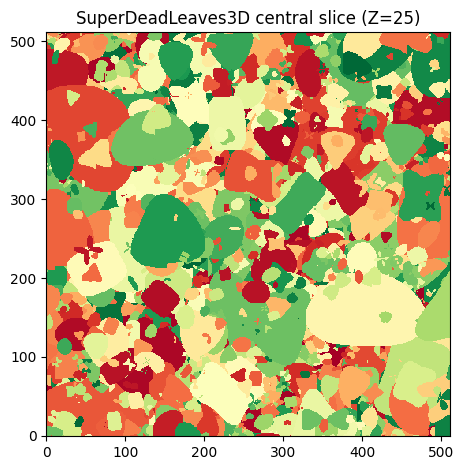

In [372]:
# Step 6: Display the central Z slice
mid_slice = vol_size[2] // 2  # Middle slice index along Z-axis
print(f"\n   Displaying the central slice of the generated volume: Z={mid_slice}")
plt.figure()
plt.imshow(volume[:, :, mid_slice], cmap='RdYlGn', origin='lower', interpolation='nearest')  # nipy_spectral 
plt.title(f"SuperDeadLeaves3D central slice (Z={mid_slice})")
# plt.colorbar(label="Voxel value")
plt.tight_layout()
plt.show()

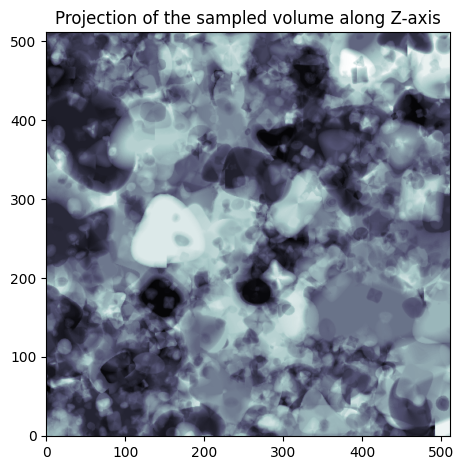

In [370]:
# Step 7: Display the projection of the volume along the Z axis
if volume.shape[2] > 1:        
    plt.imshow(volume.mean(axis=2), cmap='bone', origin='lower', interpolation='bilinear')  # 'nipy_spectral'
    plt.title(f"Projection of the sampled volume along Z-axis")
    plt.tight_layout()
    plt.show()


   Visualize the last superformula shape sampled during the volume generation, showing the points used to estimate the shape size:
     Superformula parameter: a=0.93, 1.21; b=1.10, 0.90; m=2, 4; n1=3.88, 2.44; n2=6.26, 5.89; n3=3.90, 3.96;
                             phase=284.11, 39.72; num_Fibonacci_samples=113


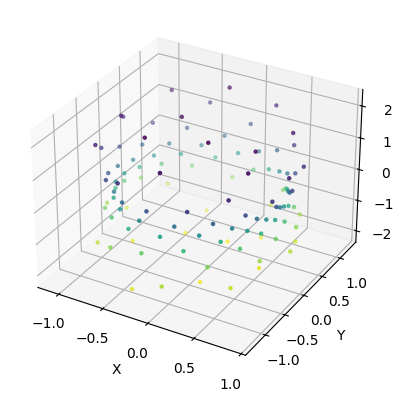

     Estimated min, max and mean radii = [0.75959164 2.3884099  1.3492851 ]

   Visualization of points sampled on a random 3D superformula shape surface:
     Superformula parameter: a=1.02, 1.17; b=0.81, 1.16; m=6, 3; n1=2.36, 2.67; n2=4.15, 4.42; n3=1.52, 4.62;
                             phase=267.26, 17.29; num_Fibonacci_samples=5000


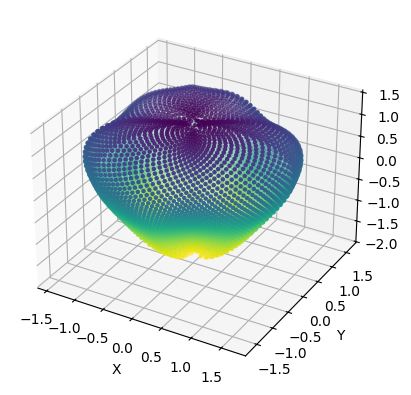

     Estimated min, max and mean radii = [1.1220769 1.8344779 1.4395086]



In [371]:
# Step 8: show example superformula shapes
print("\n   Visualize the last superformula shape sampled during the volume generation, showing the points used to estimate the shape size:")
print( f"     Estimated min, max and mean radii = {np.ravel(SDL3D.estimate_shape_size(visualize=True))}")

SDL3D_tmp = SuperDeadLeaves3D(num_shape_samples=5000)
SDL3D_tmp.sample_superformula_params()
print("\n   Visualization of points sampled on a random 3D superformula shape surface:")
print( f"     Estimated min, max and mean radii = {np.ravel(SDL3D_tmp.estimate_shape_size(visualize=True))}\n")

## Example classic Dead Leaves chart created with the SuperDeadLeaves3D generator

In [116]:
# ** Generate a classic Dead Leaves image **

# Step 1: Define the volume size
vol_size = [1024, 1024, 1]

# Step 2: Initialize the SuperDeadLeaves3D generator
seed = np.random.randint(1e4, 1e5)  # Use None for a random initialization
print(f"\n ** SuperDeadLeaves3D generator initialized with seed={seed} and volume size={vol_size} **\n")

SDL3D = SuperDeadLeaves3D(vol_size, seed=seed, m_range1=[0,0], m_range2=[0,0], rmin=0.001, rmax=0.15, PowerLawExp=3, num_shape_samples=1)

# Step 3: Generate the volume
max_shapes = 65500
print(f"   Starting volume generation with up to {max_shapes} shapes...")
start_time = time.time()  # Record start time    

volume = SDL3D.generate(max_shapes=max_shapes, enumerate_shapes=True, verbose=True)  

end_time = time.time()  # Record end time
generation_time = end_time - start_time
print(f"\n   Volume generation completed in {generation_time:.2f} sec ({SDL3D.final_shapes/generation_time:2f} shapes/sec).")

# Step 4: Export the volume as a multi-page TIFF file with the correct axis order for ImageJ (TZCYX)
output_file = f"DeadLeaves_{seed}_shapes{SDL3D.final_shapes}_rmin{SDL3D.rmin}_{vol_size[0]}x{vol_size[1]}.tif"
print(f"   Exporting the final image to file: {output_file}")   
tifffile.imwrite(output_file, volume.squeeze())

# Step 5: Report basic statistics about the volume
filled_voxels = np.count_nonzero(volume)  # Count filled voxels
unique_shapes = np.max(volume)  # Count unique shapes
total_voxels  = np.prod(vol_size)  # Total voxels in the volume

print(f"\n   Volume Statistics (volume.shape={volume.shape}):")
print(  f"     Total Voxels: {total_voxels}")
print(  f"     Filled Voxels: {filled_voxels}")
print(  f"     Unique Shapes: {unique_shapes}")
print(  f"     Percentage Filled: {filled_voxels / total_voxels * 100:.2f}%")


 ** SuperDeadLeaves3D generator initialized with seed=42335 and volume size=[1024, 1024, 1] **

   Starting volume generation with up to 65500 shapes...
     Shape 500: Filled 17581/1048576 voxels =  1.677%. Runtime: 0.49 s.
     Shape 1000: Filled 35349/1048576 voxels =  3.371%. Runtime: 0.91 s.
     Shape 1500: Filled 62654/1048576 voxels =  5.975%. Runtime: 1.35 s.
     Shape 2000: Filled 79238/1048576 voxels =  7.557%. Runtime: 1.80 s.
     Shape 2500: Filled 87215/1048576 voxels =  8.317%. Runtime: 2.22 s.
     Shape 3000: Filled 96790/1048576 voxels =  9.231%. Runtime: 2.62 s.
     Shape 3500: Filled 139050/1048576 voxels = 13.261%. Runtime: 3.05 s.
     Shape 4000: Filled 176342/1048576 voxels = 16.817%. Runtime: 3.46 s.
     Shape 4500: Filled 182899/1048576 voxels = 17.443%. Runtime: 3.88 s.
     Shape 5000: Filled 190865/1048576 voxels = 18.202%. Runtime: 4.30 s.
     Shape 5500: Filled 203520/1048576 voxels = 19.409%. Runtime: 4.71 s.
     Shape 6000: Filled 213496/1048576 


   Displaying the central slice of the generated volume: Z=0


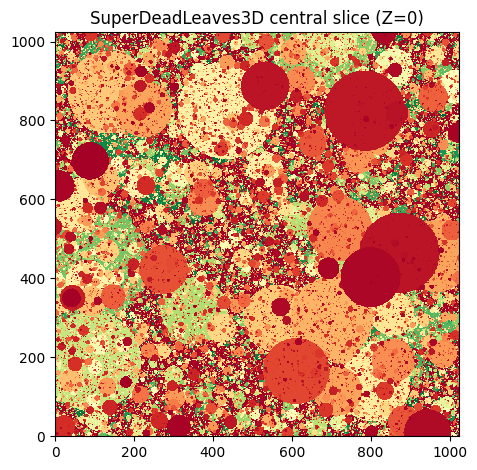

In [117]:
# Step 6: Display the central Z slice
mid_slice = vol_size[2] // 2  # Middle slice index along Z-axis
print(f"\n   Displaying the central slice of the generated volume: Z={mid_slice}")
plt.figure()
plt.imshow(volume[:, :, mid_slice], cmap='RdYlGn', origin='lower', interpolation='nearest')
plt.title(f"SuperDeadLeaves3D central slice (Z={mid_slice})")
# plt.colorbar(label="Voxel value")
plt.tight_layout()
plt.show()


 ** SuperDeadLeaves3D generator initialized with seed=99888 and volume size=[512, 512, 1] **

   Starting volume generation with up to 5000 shapes...
     Shape 500: Filled 56719/262144 voxels = 21.637%. Runtime: 2.25 s.

 ...stopping the generation after 200 consecutive shapes failed to cover any voxel (final_shapes=518)...


   Volume generation completed in 2.39 sec (2.167634e+02 shapes/sec).

   Displaying the central slice of the generated volume: Z=0


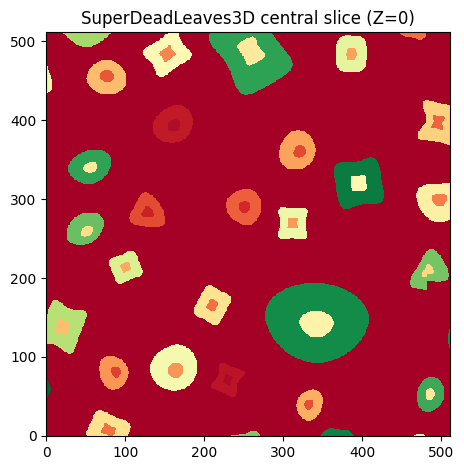

In [364]:
# ** Generate a SuperDeadLeaves3D volume without overlapping and cell nucleus **

vol_size = [512, 512, 1]
max_shapes = 10000

seed = np.random.randint(1e4, 1e5)  # Use None for a random initialization
print(f"\n ** SuperDeadLeaves3D generator initialized with seed={seed} and volume size={vol_size} **\n")

SDL3D = SuperDeadLeaves3D(vol_size, seed=seed, m_range1=[2, 6], m_range2=[2, 4], n1_range=[2, 5], n2_range=[5, 9], n3_range=[2, 5], rmin=0.04)  # 0.0015

print(f"   Starting volume generation with up to {max_shapes} shapes...")
start_time = time.time()  # Record start time    

volume = SDL3D.generate(max_shapes=max_shapes, enumerate_shapes=False, overlap_factor=1.5, nucleus_fraction=0.0, verbose=True)  

end_time = time.time()  # Record end time
generation_time = end_time - start_time
print(f"\n   Volume generation completed in {generation_time:.2f} sec ({(SDL3D.final_shapes/generation_time):2e} shapes/sec).")

#output_file = f"SuperDeadLeaves3D_{seed}_shapes{SDL3D.final_shapes}_rmin{SDL3D.rmin}_{vol_size[0]}x{vol_size[1]}x{vol_size[2]}.tif"
#print(f"   Exporting the final volume to file: {output_file}")   
#tifffile.imwrite(output_file, volume.transpose(2,1,0))

# Display the central Z slice
mid_slice = vol_size[2] // 2  # Middle slice index along Z-axis
print(f"\n   Displaying the central slice of the generated volume: Z={mid_slice}")
plt.figure()
plt.imshow(volume[:, :, mid_slice], cmap='RdYlGn', origin='lower', interpolation='nearest')
plt.title(f"SuperDeadLeaves3D central slice (Z={mid_slice})")
plt.tight_layout()
plt.show()


 ** SuperDeadLeaves3D generator initialized with seed=28403 and volume size=[512, 512, 1] **

   Starting volume generation with up to 5000 shapes...
     Shape 500: Filled 88385/262144 voxels = 33.716%. Runtime: 0.74 s.
     Shape 1000: Filled 95937/262144 voxels = 36.597%. Runtime: 1.49 s.

 ...stopping the generation after 200 consecutive shapes failed to cover any voxel (final_shapes=1021)...


   Volume generation completed in 1.53 sec (6.682607e+02 shapes/sec).

   Displaying the central slice of the generated volume: Z=0


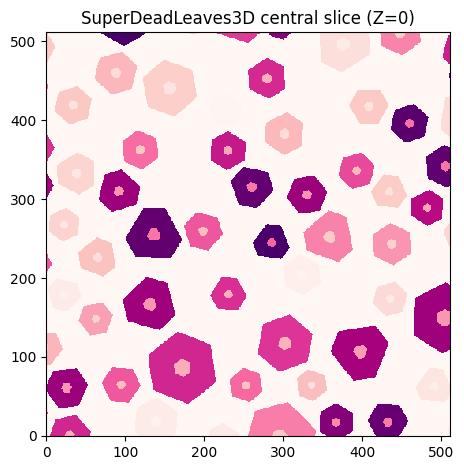

In [360]:
# ** Generate a SuperDeadLeaves3D volume without overlapping and with cell nucleus looking like hexagons **

vol_size = [512, 512, 1]
max_shapes = 10000

seed = np.random.randint(1e4, 1e5)  # Use None for a random initialization
print(f"\n ** SuperDeadLeaves3D generator initialized with seed={seed} and volume size={vol_size} **\n")

# SDL3D = SuperDeadLeaves3D(vol_size, seed=seed, m_range1=[2, 6], m_range2=[2, 4], n1_range=[2, 5], n2_range=[5, 9], n3_range=[2, 5], rmin=0.025)  # 0.0015

# Hexagons:
SDL3D = SuperDeadLeaves3D(vol_size, seed=seed, m_range1=[4, 4], m_range2=[6, 6], n1_range=[100,100], n2_range=[39, 39], n3_range=[39, 39], rmin=0.04, rmax=0.10)

print(f"   Starting volume generation with up to {max_shapes} shapes...")
start_time = time.time()  # Record start time    

volume = SDL3D.generate(max_shapes=max_shapes, enumerate_shapes=False, overlap_factor=1.25, nucleus_fraction=0.333, verbose=True)  

end_time = time.time()  # Record end time
generation_time = end_time - start_time
print(f"\n   Volume generation completed in {generation_time:.2f} sec ({(SDL3D.final_shapes/generation_time):2e} shapes/sec).")

#output_file = f"SuperDeadLeaves3D_{seed}_shapes{SDL3D.final_shapes}_rmin{SDL3D.rmin}_{vol_size[0]}x{vol_size[1]}x{vol_size[2]}.tif"
#print(f"   Exporting the final volume to file: {output_file}")   
#tifffile.imwrite(output_file, volume.transpose(2,1,0))

# Display the central Z slice
mid_slice = vol_size[2] // 2  # Middle slice index along Z-axis
print(f"\n   Displaying the central slice of the generated volume: Z={mid_slice}")
plt.figure()
plt.imshow(volume[:, :, mid_slice], cmap='RdPu', origin='lower', interpolation='nearest')
plt.title(f"SuperDeadLeaves3D central slice (Z={mid_slice})")
plt.tight_layout()
plt.show()